<a href="https://colab.research.google.com/github/Adam-Aber/OEDI-Dataset-Data-Preprocessing/blob/main/OEDI_Dataset_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("df.csv")
print(f"Original Dataset Size: {df.shape}")

Original Dataset Size: (560655, 13)


In [ ]:
# Identify columns with numerical values to scale
numerical_cols = [col for col in df.columns if "[kW]" in col]

# Apply log transformation (log(x + 1)) followed by standardization
df_log = df[numerical_cols].apply(np.log1p)
scaler = StandardScaler()
df_log_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=[f"{col}_log_scaled" for col in numerical_cols])
print("Performed log transformation and standardization successfully")

Performed log transformation and standardization successfully


In [ ]:
# These are the features to keep as they are from original dataset
last_two_cols = df.iloc[:, -2:].columns  # Last 2 columns (Class and theft)
df_last_two = df[last_two_cols]

# Combine with the scaled numerical features
df_normalized = pd.concat([df_last_two, df_log_scaled], axis=1)
print("Combined the last two columns with the log-scaled numerical features")

Combined the last two columns with the log-scaled numerical features


In [ ]:
# Convert 'theft' column to binary (0 for normal and 1 for theft)
df_normalized["theft_binary"] = df_normalized["theft"].apply(lambda x: 0 if x == "Normal" else 1)
print("Converted 'theft' column to binary")


Converted 'theft' column to binary


In [ ]:
# Find correlations in [0, 1] range using absolute value
correlations = df_normalized[[f"{col}_log_scaled" for col in numerical_cols] + ["theft_binary"]].corr()["theft_binary"].drop("theft_binary")
correlations_abs = correlations.abs()
print("\nCorrelation of the numerical features with Theft (Binary):")
print(correlations_abs)


Correlation of the numerical features with Theft (Binary):
Electricity:Facility [kW](Hourly)_log_scaled             0.308819
Fans:Electricity [kW](Hourly)_log_scaled                 0.173962
Cooling:Electricity [kW](Hourly)_log_scaled              0.083642
Heating:Electricity [kW](Hourly)_log_scaled              0.038806
InteriorLights:Electricity [kW](Hourly)_log_scaled       0.250624
InteriorEquipment:Electricity [kW](Hourly)_log_scaled    0.284878
Gas:Facility [kW](Hourly)_log_scaled                     0.164465
Heating:Gas [kW](Hourly)_log_scaled                      0.084933
InteriorEquipment:Gas [kW](Hourly)_log_scaled            0.122722
Water Heater:WaterSystems:Gas [kW](Hourly)_log_scaled    0.128854
Name: theft_binary, dtype: float64


In [ ]:
# Drop features with correlation less than 0.1
correlation_threshold = 0.1
low_correlation = correlations_abs[correlations_abs < correlation_threshold].index.tolist()
print(f"\nFeatures to drop (correlation < {correlation_threshold}): {low_correlation}")

df_normalized = df_normalized.drop(columns=low_correlation)


Features to drop (correlation < 0.1): ['Cooling:Electricity [kW](Hourly)_log_scaled', 'Heating:Electricity [kW](Hourly)_log_scaled', 'Heating:Gas [kW](Hourly)_log_scaled']


In [ ]:
# Update numerical_cols to reflect dropped features
remaining_numerical_cols = [col for col in numerical_cols if f"{col}_log_scaled" not in low_correlation]
print(f"\nRemaining numerical columns after dropping low correlation: {remaining_numerical_cols}")


Remaining numerical columns after dropping low correlation: ['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)', 'InteriorEquipment:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'Water Heater:WaterSystems:Gas [kW](Hourly)']


In [ ]:
# Missing Values
print("\nMissing Values in Each Column:")
print(df_normalized.isnull().sum())
# for col in [f"{col}_log_scaled" for col in remaining_numerical_cols]:
#     if df_normalized[col].isnull().sum() > 0:
#         df_normalized[col].fillna(df_normalized[col].median(), inplace=True)
#         print(f"\nFilled missing values in {col} with median")


Missing Values in Each Column:
Class                                                    0
theft                                                    0
Electricity:Facility [kW](Hourly)_log_scaled             0
Fans:Electricity [kW](Hourly)_log_scaled                 0
InteriorLights:Electricity [kW](Hourly)_log_scaled       0
InteriorEquipment:Electricity [kW](Hourly)_log_scaled    0
Gas:Facility [kW](Hourly)_log_scaled                     0
InteriorEquipment:Gas [kW](Hourly)_log_scaled            0
Water Heater:WaterSystems:Gas [kW](Hourly)_log_scaled    0
theft_binary                                             0
dtype: int64


In [ ]:
# Categorical Features
print("\nUnique Values in 'Class':")
print(df_normalized["Class"].value_counts())
print("\nUnique Values in 'theft':")
print(df_normalized["theft"].value_counts())


Unique Values in 'Class':
Class
FullServiceRestaurant     35040
Hospital                  35040
LargeHotel                35040
LargeOffice               35040
MediumOffice              35040
MidriseApartment          35040
OutPatient                35040
PrimarySchool             35040
QuickServiceRestaurant    35040
SecondarySchool           35040
SmallHotel                35040
SmallOffice               35040
Stand-aloneRetail         35040
StripMall                 35040
SuperMarket               35040
Warehouse                 35040
0                            15
Name: count, dtype: int64

Unique Values in 'theft':
theft
Normal    331824
Theft1     51083
Theft3     44349
Theft4     41460
Theft6     35413
Theft5     33553
Theft2     22973
Name: count, dtype: int64


In [ ]:
# Remove instances where Class is "0"
# df = df[df["Class"] != "0"]
# print(f"Dataset size after removing Class '0': {df.shape}")

In [ ]:
# One-hot encoding 'Class' for binary classification
df_encoded = pd.get_dummies(df_normalized, columns=["Class"], prefix="Class")
print("Performed one-hot encoding for 'Class' successfully")

Performed one-hot encoding for 'Class' successfully


In [ ]:
# Drop original 'theft' since we are using theft_binary for binary classification
df_encoded = df_encoded.drop(columns=["theft"])

# Save the cleaned and preprocessed dataset
df_encoded.to_csv("cleaned_oedi_dataset.csv", index=False)
print("\nCleaned and preprocessed dataset saved as 'cleaned_oedi_dataset.csv'")


Cleaned and preprocessed dataset saved as 'cleaned_oedi_dataset.csv'


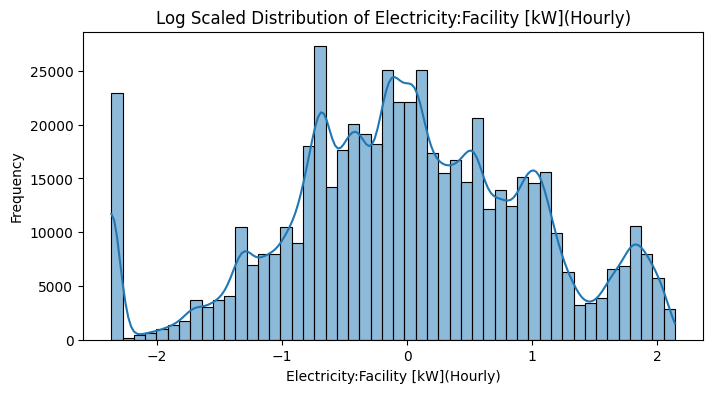

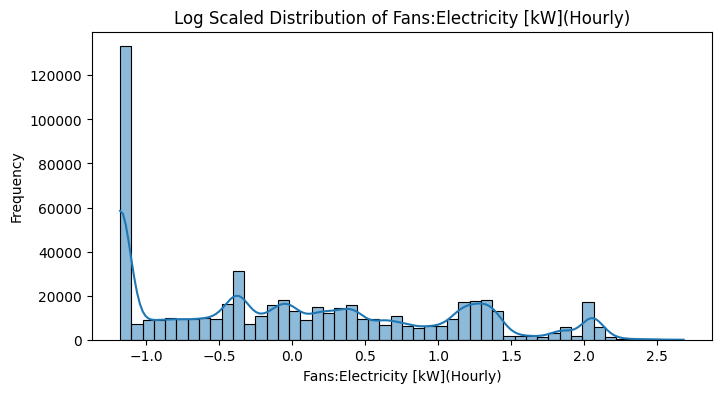

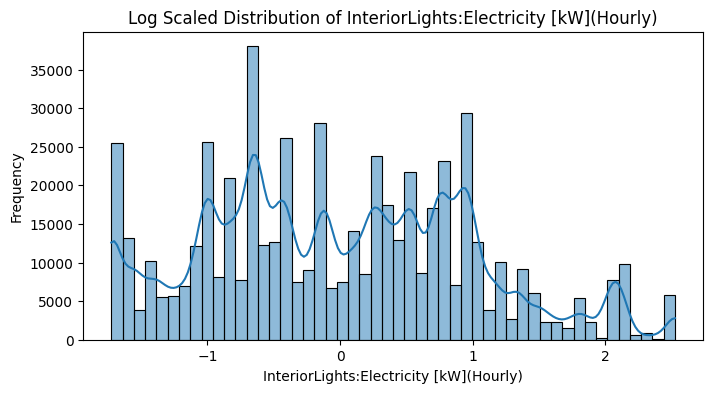

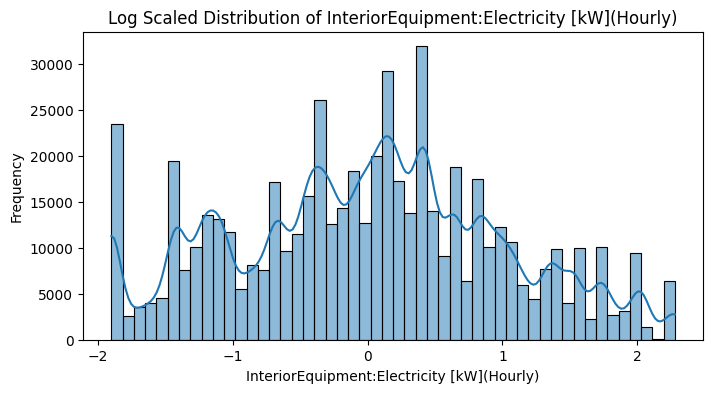

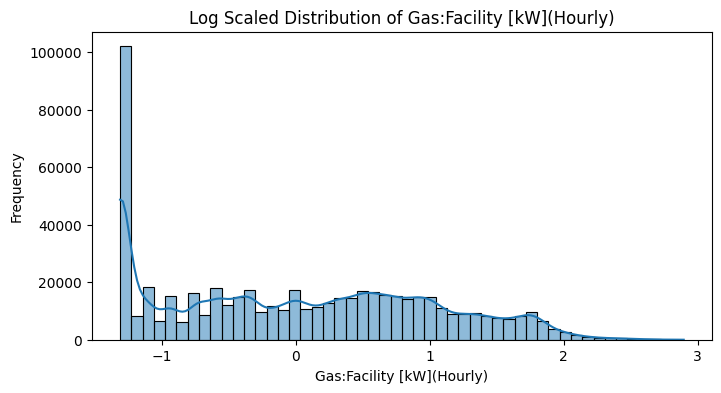

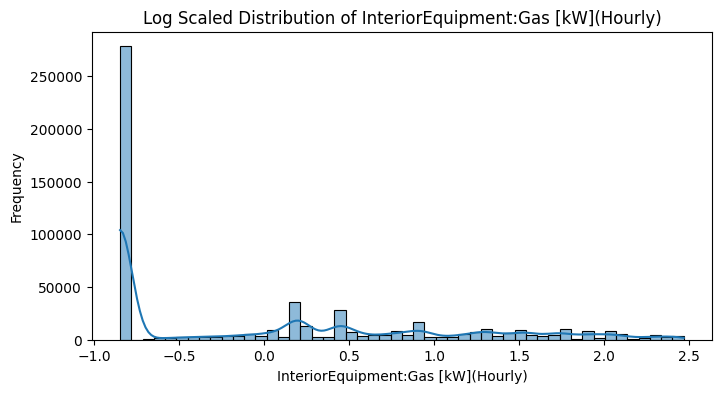

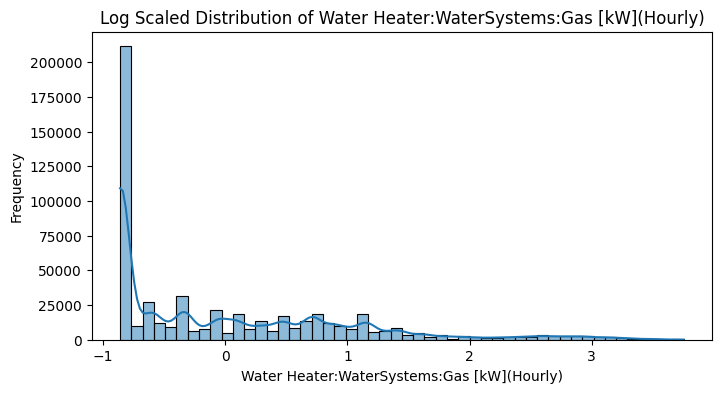

In [ ]:
# Visualize remaining normalized distributions
for col in [f"{col}_log_scaled" for col in remaining_numerical_cols]:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_normalized[col], bins=50, kde=True)
    plt.title(f"Log Scaled Distribution of {col.replace('_log_scaled', '')}")
    plt.xlabel(col.replace('_log_scaled', ''))
    plt.ylabel("Frequency")
    plt.savefig(f"log_dist_{col.replace(':', '_').replace('_log_scaled', '')}.png")
    plt.show()

In [ ]:
print(f"Cleaned Dataset Size: {df_encoded.shape}")

Cleaned Dataset Size: (560655, 25)
